In [1]:
from netCDF4 import Dataset
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import os
from glob import glob
import tqdm
import pandas as pd
import datetime


import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from pathlib import Path # Path library

import statsmodels.api as sm

sonde_dir = '../data/MOSAiC/sondes/'

result = [y for x in os.walk(sonde_dir) for y in glob(os.path.join(x[0], '*.nc'))]

In [9]:
Dataset(result[0]).variables.keys()

dict_keys(['time', 'alt', 'alt_uc', 'alt_amsl', 'alt_amsl_uc', 'alt_amsl_uc_ucor', 'alt_amsl_uc_tcor', 'alt_wgs84', 'alt_wgs84_uc', 'alt_wgs84_uc_ucor', 'alt_wgs84_uc_tcor', 'alt_gph', 'alt_gph_uc', 'alt_gph_uc_ucor', 'alt_gph_uc_tcor', 'lon', 'lon_uc', 'lon_uc_ucor', 'lon_uc_tcor', 'lat', 'lat_uc', 'lat_uc_ucor', 'lat_uc_tcor', 'press', 'press_uc', 'press_sens', 'press_sens_uc', 'press_sens_uc_ucor', 'press_sens_uc_tcor', 'press_sens_uc_tcor_cal', 'press_sens_uc_ucor_sm', 'press_sens_corr', 'press_sens_corr_cal', 'press_sens_corr_sm', 'press_gnss', 'press_gnss_uc', 'press_gnss_uc_ucor', 'press_gnss_uc_tcor', 'temp', 'temp_uc', 'temp_uc_ucor', 'temp_uc_scor', 'temp_uc_tcor', 'temp_uc_rad', 'temp_uc_ucor_rad', 'temp_uc_scor_rad', 'temp_uc_tcor_rad', 'temp_uc_tcor_cal', 'temp_uc_ucor_sm', 'temp_corr', 'temp_corr_rad', 'temp_corr_sm', 'temp_res', 'rh', 'rh_uc', 'rh_uc_ucor', 'rh_uc_tcor', 'rh_uc_tlc', 'rh_uc_ucor_tlc', 'rh_uc_tcor_tlc', 'rh_uc_tcor_cal', 'rh_uc_ucor_sm', 'rh_uc_tcor_tint'

In [4]:
list_of_dicts = []

for f in tqdm(result[:]):
    
    d = Dataset(f)
    datestring = d['time'].units.split(' ')[-1]
    dt0 = dateutil.parser.parse(datestring)
    lon0, lat0 = float(d['lon'][0]), float(d['lat'][0])

    alt = np.array(d['alt'])
    temp = np.array(d['temp'])-273.15
    wind = np.array(d['wspeed'])
    
    # Calculate inversion heights and strengths
    
    t0 = np.nanmedian(temp[(alt<10) & (alt>-10)])
    inversion_height = alt[np.argmax(temp)]
    inversion_strength = np.max(temp) - t0
    
    # Calculate low-level stability (850-2m tempreture)
    
    press = np.array(d['press'])
    t850hpa = temp[np.argmin(np.abs(press-850))]
    t2m = temp[np.argmin(np.abs(alt-2))]
    lls = t850hpa - t2m
    
    rh = np.asarray(d['rh'])/100
    rh_sub_850 = np.nanmean(rh[press<851])
    
    w0 = np.nanmedian(wind[(alt<10) & (alt>-10)])
    w850 = wind[np.argmin(np.abs(press-850))]
    

    dic = {'t0':t0,
           'dt0':dt0,
           'month':dt0.month,
           'lon':lon0,
           'lat':lat0,
           'inversion_strength':inversion_strength,
           'inversion_height':inversion_height,
           'low_level_stability':lls,
           't_850hpa':t850hpa,
           'rh_sub_850':rh_sub_850,
           'surf_wind_velocity':w0,
           'wind_shear':w850-w0,
          }
    
    list_of_dicts.append(dic)
    
df = pd.DataFrame(list_of_dicts)

  0%|          | 3/624 [00:00<01:52,  5.52it/s]/Users/ali/opt/anaconda3/envs/acdc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
 76%|███████▌  | 475/624 [01:21<00:24,  6.03it/s]/Users/ali/opt/anaconda3/envs/acdc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|██████████| 624/624 [01:47<00:00,  5.83it/s]


In [5]:
df_sondes = df.copy()

In [6]:
df_sondes

,t0,dt0,month,lon,lat,inversion_strength,inversion_height,low_level_stability,t_850hpa,rh_sub_850,surf_wind_velocity,wind_shear
0,-27.561951,2020-02-16 22:43:34.370000+00:00,2,79.627572,88.069349,6.222931,579.749268,5.231018,-22.340195,0.273186,6.142340,1.432100
1,-23.267990,2020-02-24 16:52:23.852000+00:00,2,52.539957,88.584139,NaN,17379.167969,5.955933,-17.312057,0.339253,12.822152,6.246299
2,-24.137451,2020-02-25 16:51:36.069000+00:00,2,44.385008,88.549541,6.794998,570.027283,4.590500,-19.546951,0.224312,12.269664,9.219295
3,NaN,2020-02-15 22:44:46.693000+00:00,2,79.744262,88.067856,NaN,494.141846,10.335236,-26.076447,0.228418,NaN,NaN
4,-29.049454,2020-02-26 16:49:32.343000+00:00,2,39.222764,88.473025,8.806351,890.785461,8.317902,-20.591187,0.274485,8.542025,4.615234
...,...,...,...,...,...,...,...,...,...,...,...,...
619,NaN,2020-01-03 22:50:04.390000+00:00,1,115.546444,86.954808,NaN,12420.911133,6.965759,-17.073944,0.278028,NaN,NaN
620,-26.243912,2020-01-26 10:54:35.932000+00:00,1,93.679801,87.415841,6.904388,513.987671,4.768631,-21.475281,0.253483,5.623881,4.731204
621,-25.514267,2020-01-04 22:49:24.713000+00:00,1,115.339948,87.040306,6.743668,1154.372803,6.662201,-18.852066,0.207381,5.384744,1.662308
622,NaN,2020-01-24 04:55:36.050000+00:00,1,93.267425,87.424958,NaN,434.193237,10.026321,-21.034790,0.289284,NaN,NaN


In [31]:
df_c = df_sondes.dropna(subset = ['dt0', 'low_level_stability'])

df_c['dt_'] = [x.to_datetime64() for x in df_c['dt0']]

df_c = df_c[df_c['dt_'] < datetime.datetime(2020,7,1)]
df_c = df_c[df_c['dt_'] > datetime.datetime(2019,10,15)]

df_c.to_csv('../data/tables/MOSAiC_sondes.csv')

/var/folders/_3/z3f8pgvj6fq3_sgjypm06h6r0000gn/T/ipykernel_3931/3348704013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['dt_'] = [x.to_datetime64() for x in df_c['dt0']]


In [33]:
df_c['time'] = df_c['dt0']
df_sondes_sorted = df_c.set_index('time').sort_index()
df_sondes_sorted

,t0,dt0,month,lon,lat,inversion_strength,inversion_height,low_level_stability,t_850hpa,rh_sub_850,surf_wind_velocity,wind_shear,dt_
time,,,,,,,,,,,,,
2019-10-31 22:55:09.757000+00:00,-24.483231,2019-10-31 22:55:09.757000+00:00,10,123.109808,85.794717,7.719315,677.768738,3.039383,-21.432983,0.172249,3.089488,3.799795,2019-10-31 22:55:09.757
2019-11-01 04:56:50.315000+00:00,-18.683792,2019-11-01 04:56:50.315000+00:00,11,122.969024,85.808400,3.861588,414.938721,-4.954498,-23.888641,0.161843,1.846944,3.294203,2019-11-01 04:56:50.315
2019-11-01 10:55:53.717000+00:00,NaN,2019-11-01 10:55:53.717000+00:00,11,122.841171,85.819359,NaN,440.100037,-5.534912,-24.024567,0.161056,NaN,NaN,2019-11-01 10:55:53.717
2019-11-01 16:51:40.040000+00:00,-18.477798,2019-11-01 16:51:40.040000+00:00,11,122.771985,85.831256,1.833145,539.540283,-6.124939,-24.602737,0.184259,5.201878,-2.693986,2019-11-01 16:51:40.040
2019-11-01 22:53:41.759000+00:00,-18.432388,2019-11-01 22:53:41.759000+00:00,11,122.683449,85.838081,0.892715,519.692627,-6.787262,-25.219650,0.205715,1.418454,4.227781,2019-11-01 22:53:41.759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 16:54:40.827000+00:00,-28.804062,2020-03-30 16:54:40.827000+00:00,3,13.282623,85.370027,8.152771,454.131195,6.680191,-22.123871,0.178671,5.072469,6.569064,2020-03-30 16:54:40.827
2020-03-30 22:45:17.310000+00:00,-29.488251,2020-03-30 22:45:17.310000+00:00,3,13.429095,85.356679,8.784164,564.897217,7.987000,-21.287491,0.195274,6.540287,5.324797,2020-03-30 22:45:17.310
2020-03-31 04:50:43.813000+00:00,-29.847366,2020-03-31 04:50:43.813000+00:00,3,13.646492,85.333472,10.319397,817.890320,9.270493,-20.564697,0.255228,7.404456,8.000755,2020-03-31 04:50:43.813


In [11]:
### now read in tower data (slow)
import xarray as xr
ds_tower = xr.open_mfdataset('../data/MOSAiC/tower/*.nc')

In [12]:
ds_tower

<xarray.Dataset>
Dimensions:                     (time: 38880)
Coordinates:
  * time                        (time) datetime64[ns] 2019-10-15 ... 2020-09-...
Data variables: (12/220)
    base_time                   (time) datetime64[ns] 2019-10-15 ... 2020-09-18
    time_offset                 (time) datetime64[ns] dask.array<chunksize=(144,), meta=np.ndarray>
    lat_tower                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    lon_tower                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    tower_heading               (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    mast_heading                (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    ...                          ...
    sigW_10m                    (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    sigW_mast                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hs_10m                 (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hl_10m                 (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hl_Webb_10m            (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_ustar                  (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
Attributes: (12/22)
    date_created:              Fri Feb  3 13:30:54 2023
    title:                     MOSAiC flux group data product
    contact:                   Matthew Shupe, University of Colorado, matthew...
    institution:               CIRES, University of Colorado and NOAA Physica...
    file_creator:              Michael R. Gallagher; Christopher J. Cox
    creator_email:             michael.r.gallagher@noaa.gov; christopher.j.co...
    ...                        ...
    instrument_heights:        Instruments were installed at nominal heights....
    quality_control:           Significant quality control is in place for th...
    qc_flags:                  -1 = No Data: Instrument was not functional an...
    wind_sector_qc_info_flag:  Quality control flags specifically for wind se...
    turbulence_qc_flags:       Applies to all derived EC-based turbulence par...
    bulk_qc_flags:             Applies to all derived bulk-based turbulence p...

In [35]:
# Extract the relevant variables.
T2m = ds_tower.temp_2m               # 2-m air temperature
LWdown = ds_tower.down_long_hemisp   # downwelling LW radiation
LWup = ds_tower.up_long_hemisp    # upwelling LW radiation
lat = ds_tower.lat_tower
lon = ds_tower.lon_tower


T2m.load()
LWdown.load()
LWup.load()
lat.load()
lon.load()


<xarray.DataArray 'lon_tower' (time: 38880)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2019-10-15 ... 2020-09-18T23:50:00
Attributes:
    units:               degrees_east
    long_name:           longitude from gps at the tower
    cf_name:             longitude
    qc_varname:          Corresponding quality control variable is "lon_tower...
    instrument:          Hemisphere V102
    methods:             $GPRMC, $GPGGA, GPGZDA
    height:              N/A
    location:            first level on met city tower
    platform:            10-m Met Tower
    data_provenance:     Based on data from the mosflxtowerslow.level1 datast...
    measurement_source:  CIRES, University of Colorado / NOAA atmospheric sur...
    funding_sources:     National Science Foundation OPP1724551 and NOAA Phys...
    percent_missing:     100.0

In [37]:
# Dataframe with all the data from the tower (2m air temp, LWin, LWout for all timestamps)
df_tower = pd.concat([T2m.to_dataframe(),LWdown.to_dataframe(),LWup.to_dataframe(),
                      lat.to_dataframe(), lon.to_dataframe(),
                      ], axis=1)
print(df_tower.shape)
# Remove rows where there is one missing value
df_tower_cleaned = df_tower.dropna(axis=0, how='any')
print(df_tower_cleaned.shape)
df_tower_cleaned.head()

(38880, 5)
(28559, 5)


,temp_2m,down_long_hemisp,up_long_hemisp,lat_tower,lon_tower
time,,,,,
2019-10-24 05:30:00,-11.246544,256.046144,266.583426,85.389681,129.175783
2019-10-24 05:40:00,-11.467641,256.559166,266.193354,85.390212,129.169891
2019-10-24 05:50:00,-11.478930,256.149529,266.114215,85.390751,129.163813
2019-10-24 06:00:00,-11.430214,255.778907,266.241283,85.391269,129.157630
2019-10-24 06:10:00,-11.433075,255.584326,266.302178,85.391773,129.151184


In [40]:
### now merge

tolerance = "5min"
DF = pd.merge_asof(df_sondes_sorted, df_tower_cleaned, left_index=True, right_index=True, 
                        tolerance=pd.Timedelta(tolerance),
                      allow_exact_matches=True, direction='nearest').dropna()
DF 

DF['month'] = DF.index.month
DF['rlns'] = DF['down_long_hemisp'] - DF['up_long_hemisp']
#DF['low_level_stability'] = DF['T850']-DF['temp_2m']
DF
DF.to_csv('../data/tables/MOSAiC_merged.csv')

# <b> Processing of MOSAiC observations

Processing the **surface radiative flux and temp data for MOSAiC**, add it as a panel to the multi-model comparison of 2d histograms of low level stability against surface net LW. 

We need a csv with columns **[2-m temp, 850-hPa temp, LW$_{down}$, LW$_{up}$] and a row per observation**.

We should also **resample the data up to 6 hourly resolution** prior to processing, so as to be a fair comparison against the models.

# Questions
- How far in time can the measurements of sondes and tower be apart?

# Preparations

## Load modules

In [3]:
#%run jupyter_startup.ipy   # in meinem jupyter_startup.ipy File stehen alle Befehle/Packages drin, die ich standardmäßig geladen haben möchte    
import numpy as np
import pandas as pd
import xarray as xr
import glob
import os
from netCDF4 import Dataset

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from pathlib import Path # Path library

import statsmodels.api as sm

#os.system('module load nco')
#os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [4]:
# Set pressure threshold to 850hPa. Here we want to know the temperature.
pressure_threshold = 850

# <b> Radiosondes

<div class="alert alert-block alert-info">
CHANGE PATH HERE

In [5]:
# extract paths of all radiosonde profiles
paths = []
for path in Path('../data/MOSAiC/sondes/').rglob('*.nc'):
    paths.append(str(path))

In [6]:
#xr.open_dataset('../data/MOSAiC/sondes/MOSAiC_radiosondes_02_2020_GRUAN/PST-RS-01_2_RS41-GDP_001_20200217T000000_1-000-001.nc')


In [7]:
p850temptime = []
# For each radiosonde-profile, determine the temperature at 85hPa and save the value together with the timestamp of the measurement
for path in tqdm(paths):
    ds_sonde = xr.open_dataset(path)  # open one radiosonde-profile in a dataset
    try:
        # Calculate pressure value at 850hPa and determine timestamp.
        press_850 = (ds_sonde.press.where((ds_sonde.press - pressure_threshold) < 10**(-5), drop=True)).isel(time=0)
        # Create list of dictionaries to make dataframe
        p850temptime.append(
            {
                'time': press_850.time.values,
                # Extract temperature value at exact timestamp when 850hPa were reached with the sonde. Convert into °C.
                'T850':  float((ds_sonde.temp.sel(time=press_850.time.values) - 273.15).values),
                # Extract the uncertainties of the temperature measurements
                'T850_uc': float(ds_sonde.temp_uc.sel(time=press_850.time.values).values)
            }
        )
    except:
        pass

100%|█████████████████████████████████████████| 624/624 [01:53<00:00,  5.52it/s]


In [8]:
df_sondes = pd.DataFrame(p850temptime)
df_sondes

,time,T850,T850_uc
0,2020-02-16 22:47:48.370,-22.340201,0.238847
1,2020-02-24 16:56:17.852,-17.312064,0.238758
2,2020-02-25 16:55:44.069,-19.580557,0.238852
3,2020-02-15 22:48:48.693,-25.947256,0.248029
4,2020-02-26 16:53:59.343,-20.591193,0.238811
...,...,...,...
619,2020-01-03 22:54:43.390,-17.106482,0.216895
620,2020-01-26 10:59:27.932,-21.475287,0.076931
621,2020-01-04 22:53:50.713,-18.868628,0.214333
622,2020-01-24 05:00:49.050,-21.034796,0.194780


In [9]:
df_sondes.dropna()

,time,T850,T850_uc
0,2020-02-16 22:47:48.370,-22.340201,0.238847
1,2020-02-24 16:56:17.852,-17.312064,0.238758
2,2020-02-25 16:55:44.069,-19.580557,0.238852
3,2020-02-15 22:48:48.693,-25.947256,0.248029
4,2020-02-26 16:53:59.343,-20.591193,0.238811
...,...,...,...
619,2020-01-03 22:54:43.390,-17.106482,0.216895
620,2020-01-26 10:59:27.932,-21.475287,0.076931
621,2020-01-04 22:53:50.713,-18.868628,0.214333
622,2020-01-24 05:00:49.050,-21.034796,0.194780


In [10]:
#df_sondes.drop('T850_uc', axis=1)

In [11]:
df_sondes_sorted = df_sondes.set_index('time').sort_index()
df_sondes_sorted#.head()

,T850,T850_uc
time,,
2019-09-21 05:07:07.854,-5.327002,0.241900
2019-09-22 03:58:00.773,-6.573401,0.240488
2019-09-22 11:03:33.763,-4.199713,0.098022
2019-09-23 03:05:28.166,-4.785315,0.241602
2019-09-23 11:07:37.438,-4.619849,0.104190
...,...,...
2020-09-30 22:59:14.923,-8.713995,0.238997
2020-10-01 01:19:25.095,-8.828528,0.239044
2020-10-01 04:59:53.420,-8.560553,0.239216


<Figure size 432x288 with 0 Axes>

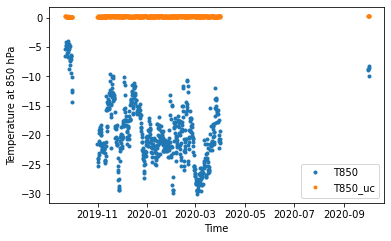

In [12]:
plt.figure()
df_sondes_sorted.plot(ls='',marker='.')
plt.xticks(rotation=None,ha='center')
plt.xlabel('Time')
plt.ylabel('Temperature at 850 hPa')
plt.show()

---

<div class="alert alert-block alert-info">
not necessary for final product, this was just testing

## Testing of Sonde-processing

In [13]:
print(paths[0])
ds = xr.open_dataset(paths[0])
ds

../data/MOSAiC/sondes/MOSAiC_radiosondes_02_2020_GRUAN/PST-RS-01_2_RS41-GDP_001_20200217T000000_1-000-001.nc


<xarray.Dataset>
Dimensions:                 (time: 5450)
Coordinates:
  * time                    (time) datetime64[ns] 2020-02-16T22:43:34.370000 ...
    alt                     (time) float32 ...
    lon                     (time) float64 ...
    lat                     (time) float64 ...
Data variables: (12/181)
    alt_uc                  (time) float32 ...
    alt_amsl                (time) float32 ...
    alt_amsl_uc             (time) float32 ...
    alt_amsl_uc_ucor        (time) float32 ...
    alt_amsl_uc_tcor        (time) float32 ...
    alt_wgs84               (time) float32 ...
    ...                      ...
    posz_raw_flags          (time) int16 ...
    lat_raw_flags           (time) int16 ...
    lon_raw_flags           (time) int16 ...
    alt_raw_flags           (time) int16 ...
    wzon_raw_flags          (time) int16 ...
    wmeri_raw_flags         (time) int16 ...
Attributes: (12/219)
    Conventions:                                       CF-1.7
    title:                                             RS41 GRUAN Data Produc...
    institution:                                       GRUAN Lead Centre (DWD...
    source:                                            Vaisala Radiosonde RS41
    history:                                           2021-12-02T21:41:46.89...
    references:                                        See the GRUAN document...
    ...                                                ...
    g.GroundCheck.SHC.TemperatureQc:                   bad
    g.GroundCheck.SHC.RelativeHumidityQc:              bad
    g.GroundCheck.SHC.RelativeHumiditySensorsQc:       no
    g.GroundCheck.SHC.Altitude:                        NaN m
    g.GroundCheck.SHC.OffsetAltitudeRefPressure:       NaN m
    g.GroundCheck.SHELTER.Available:                   no

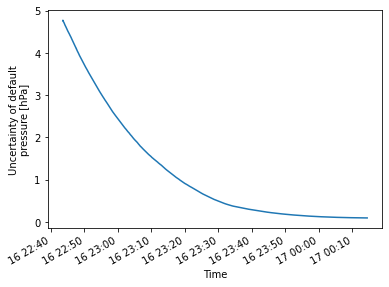

In [14]:
ds.press_uc.plot()

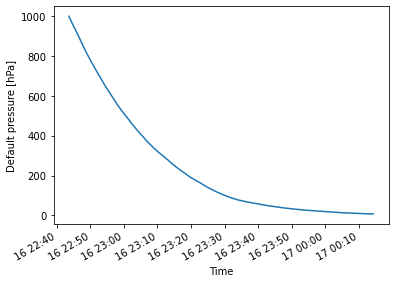

In [15]:
ds.press.plot()

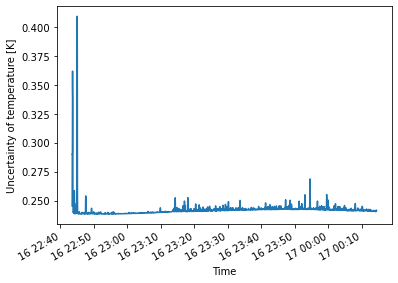

In [16]:
ds.temp_uc.plot()

In [17]:
temp = ds.temp - 273.15 # convert to °C

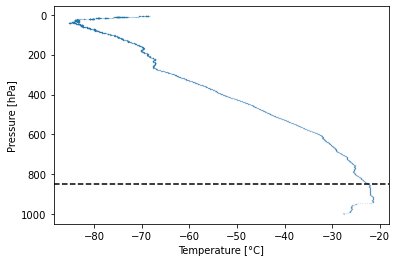

In [18]:
plt.figure()
plt.plot(temp,ds.press,ls='',marker='.',ms=.1)
plt.axhline(pressure_threshold,c='k',ls='--')
plt.ylabel('Pressure [hPa]')
plt.xlabel('Temperature [°C]')
plt.gca().invert_yaxis()
plt.show()

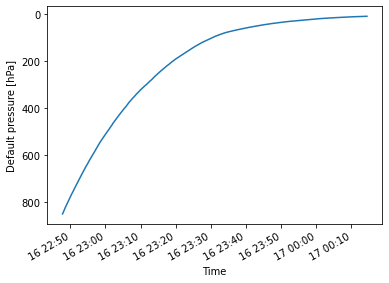

In [19]:
# extract all values that are above 850hPa, drop all below
plt.plot()
ds.press.where((ds.press - pressure_threshold) < 10**(-5), drop=True).plot()
plt.gca().invert_yaxis()
plt.show()

(0.0, 850.0)

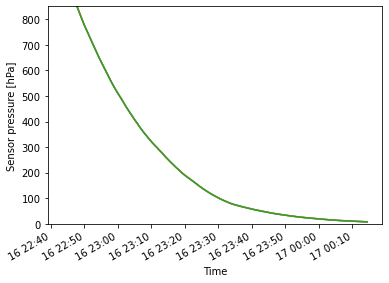

In [20]:
# Check out the different pressure-variables in the sondes-dataset -> Pressure-variables are similar!
ds.press.plot()
ds.press_gnss.plot()
ds.press_sens.plot()
plt.ylim(0,850)

Find pressure value closest to 850 hPa by taking the first timestep of the remaining data.

In [21]:
press_850 = (ds.press.where((ds.press - pressure_threshold)<10**(-5), drop=True)).isel(time=0)
press_850

<xarray.DataArray 'press' ()>
array(849.96484, dtype=float32)
Coordinates:
    time     datetime64[ns] 2020-02-16T22:47:48.370000
    alt      float32 1.183e+03
    lon      float64 79.69
    lat      float64 88.09
Attributes:
    units:                hPa
    long_name:            Default pressure
    standard_name:        air_pressure
    comment:              GNSS pressure is chosen as default pressure
    ancillary_variables:  press_uc
    valid_min:            2.0
    valid_max:            1100.0
    g_format_format:      F8.3
    g_format_nan:         NaN
    g_format_type:        FLT
    g_format_width:       8
    g_resolution:         1.0 s (time)
    g_content_type:       PRESSURE

In [22]:
# alternative way
#(ds.press.where((ds.press - pressure_threshold)<10**(-5))).max()   # this is the value closest to 85hPa

In [23]:
press_850.time.values

numpy.datetime64('2020-02-16T22:47:48.370000000')

In [24]:
# extract timestamp when 850hPa was reached and determine temperature at that time
T850 = ds.temp.sel(time=press_850.time.values) - 273.15
T850

<xarray.DataArray 'temp' ()>
array(-22.34020081)
Coordinates:
    time     datetime64[ns] 2020-02-16T22:47:48.370000
    alt      float32 1.183e+03
    lon      float64 79.69
    lat      float64 88.09

---

# <b> Tower

Variables: \
    - **temp_2m**: 2-m air temperature \
    - **down_long_hemisp**: surface_net_downward_longwave_flux \
    - **up_long_hemisp**:     surface_net_upward_longwave_flux
    
The different data variables measured by the tower all have the same times.

**Uncertainties Tower**\
qc_flags :\
    -1 = No Data: Instrument was not functional and no data exists.\
    0 = Good: High certainty that data is accurate to within the expected measurement uncertainty.\
    1 = Caution: Use data with caution as there is reason to believe that the data might have a higher uncertainty than expected and/or is adversely impacted in some way.\
    2 = Bad: Data is determined to be clearly erroneous (out of range, does not pass quality control, is adversely impacted in some way, etc). Data has been removed.\
    3 = Engineering: Data collected was designed for engineering or testing purposes and not for general scientific use.  Data has been removed.

<div class="alert alert-block alert-info">
CHANGE PATH HERE

In [25]:
ds_tower = xr.open_mfdataset('../data/MOSAiC/tower/*.nc')

In [26]:
ds_tower

<xarray.Dataset>
Dimensions:                     (time: 38880)
Coordinates:
  * time                        (time) datetime64[ns] 2019-10-15 ... 2020-09-...
Data variables: (12/220)
    base_time                   (time) datetime64[ns] 2019-10-15 ... 2020-09-18
    time_offset                 (time) datetime64[ns] dask.array<chunksize=(144,), meta=np.ndarray>
    lat_tower                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    lon_tower                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    tower_heading               (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    mast_heading                (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    ...                          ...
    sigW_10m                    (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    sigW_mast                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hs_10m                 (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hl_10m                 (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hl_Webb_10m            (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_ustar                  (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
Attributes: (12/22)
    date_created:              Fri Feb  3 13:30:54 2023
    title:                     MOSAiC flux group data product
    contact:                   Matthew Shupe, University of Colorado, matthew...
    institution:               CIRES, University of Colorado and NOAA Physica...
    file_creator:              Michael R. Gallagher; Christopher J. Cox
    creator_email:             michael.r.gallagher@noaa.gov; christopher.j.co...
    ...                        ...
    instrument_heights:        Instruments were installed at nominal heights....
    quality_control:           Significant quality control is in place for th...
    qc_flags:                  -1 = No Data: Instrument was not functional an...
    wind_sector_qc_info_flag:  Quality control flags specifically for wind se...
    turbulence_qc_flags:       Applies to all derived EC-based turbulence par...
    bulk_qc_flags:             Applies to all derived bulk-based turbulence p...

In [34]:
# Extract the relevant variables.
T2m = ds_tower.temp_2m               # 2-m air temperature
LWdown = ds_tower.down_long_hemisp   # downwelling LW radiation
LWup = ds_tower.up_long_hemisp    # upwelling LW radiation
lat = ds_tower.lat_tower
lon = ds_tower.lon_tower


T2m.load()
LWdown.load()
LWup.load()
lat.load()
lon.load()


<xarray.DataArray 'lon_tower' (time: 38880)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2019-10-15 ... 2020-09-18T23:50:00
Attributes:
    units:               degrees_east
    long_name:           longitude from gps at the tower
    cf_name:             longitude
    qc_varname:          Corresponding quality control variable is "lon_tower...
    instrument:          Hemisphere V102
    methods:             $GPRMC, $GPGGA, GPGZDA
    height:              N/A
    location:            first level on met city tower
    platform:            10-m Met Tower
    data_provenance:     Based on data from the mosflxtowerslow.level1 datast...
    measurement_source:  CIRES, University of Colorado / NOAA atmospheric sur...
    funding_sources:     National Science Foundation OPP1724551 and NOAA Phys...
    percent_missing:     100.0

In [18]:
# Dataframe with all the data from the tower (2m air temp, LWin, LWout for all timestamps)
df_tower = pd.concat([T2m.to_dataframe(),LWdown.to_dataframe(),LWup.to_dataframe(),
                      lat.to_dataframe(), lon.to_dataframe(),
                      surf_wind.to_dataframe()], axis=1)
print(df_tower.shape)


(38880, 5)


In [19]:
# Remove rows where there is one missing value
df_tower_cleaned = df_tower.dropna(axis=0, how='any')
print(df_tower_cleaned.shape)
df_tower_cleaned.head()

(28559, 5)


,temp_2m,down_long_hemisp,up_long_hemisp,lat_tower,lon_tower
time,,,,,
2019-10-24 05:30:00,-11.246544,256.046144,266.583426,85.389681,129.175783
2019-10-24 05:40:00,-11.467641,256.559166,266.193354,85.390212,129.169891
2019-10-24 05:50:00,-11.478930,256.149529,266.114215,85.390751,129.163813
2019-10-24 06:00:00,-11.430214,255.778907,266.241283,85.391269,129.157630
2019-10-24 06:10:00,-11.433075,255.584326,266.302178,85.391773,129.151184


<AxesSubplot:xlabel='time'>

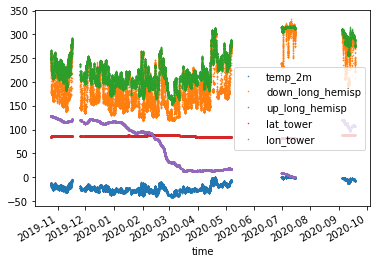

In [20]:
df_tower_cleaned.plot(ls='',marker='.',ms=1)

## drop data where quality flag indicates large uncertainties

In [21]:
# Uncertainties
T2m_uc = ds_tower.temp_2m_qc
LWdown_uc = ds_tower.down_long_hemisp_qc
LWup_uc = ds_tower.up_long_hemisp_qc

T2m_uc.load()
LWdown_uc.load()
LWup_uc.load()

<xarray.DataArray 'up_long_hemisp_qc' (time: 38880)>
array([ 3.,  3.,  3., ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2019-10-15 ... 2020-09-18T23:50:00
Attributes:
    long_name:        QC flag integer indicating data quality
    comment:          See global attributes for qc flag definitions.
    percent_missing:  0.0
    data_provenance:  Based on data from the mosseb.level2 datastream

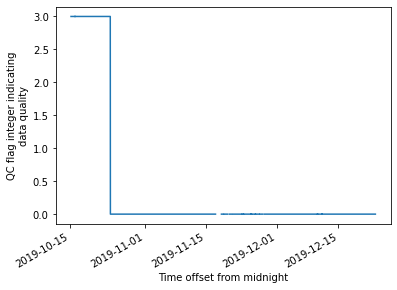

In [22]:
ds_tower.temp_2m_qc.isel(time=slice(0,10000)).plot()#.sel(time=slice('2019-10')).values

In [23]:
# Uncertainties
df_tower_uc = pd.concat([T2m_uc.to_dataframe(),LWdown_uc.to_dataframe(),LWup_uc.to_dataframe()], axis=1)

<AxesSubplot:xlabel='time'>

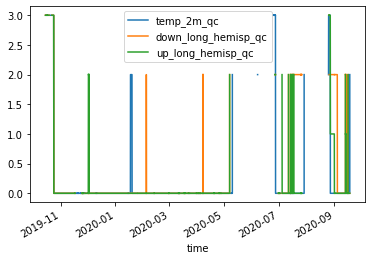

In [24]:
df_tower_uc.plot()

In [25]:
# Dataframe with all the data from the tower AND their quality flags (2m air temp, LWin, LWout for all timestamps)
df_tower_withUC = pd.concat([T2m.to_dataframe(),T2m_uc.to_dataframe(),LWdown.to_dataframe(),
                             LWdown_uc.to_dataframe(),LWup.to_dataframe(),LWup_uc.to_dataframe(),
                            lat.to_dataframe(), lon.to_dataframe()], axis=1)
print(df_tower_withUC.shape)

# Remove rows where there is one missing value
df_tower_withUC_cleaned = df_tower_withUC.dropna(axis=0, how='any')
print(df_tower_withUC_cleaned.shape)
df_tower_withUC_cleaned.head()

(38880, 8)
(28559, 8)


,temp_2m,temp_2m_qc,down_long_hemisp,down_long_hemisp_qc,up_long_hemisp,up_long_hemisp_qc,lat_tower,lon_tower
time,,,,,,,,
2019-10-24 05:30:00,-11.246544,0.0,256.046144,0.0,266.583426,0.0,85.389681,129.175783
2019-10-24 05:40:00,-11.467641,0.0,256.559166,0.0,266.193354,0.0,85.390212,129.169891
2019-10-24 05:50:00,-11.478930,0.0,256.149529,0.0,266.114215,0.0,85.390751,129.163813
2019-10-24 06:00:00,-11.430214,0.0,255.778907,0.0,266.241283,0.0,85.391269,129.157630
2019-10-24 06:10:00,-11.433075,0.0,255.584326,0.0,266.302178,0.0,85.391773,129.151184


<AxesSubplot:xlabel='time'>

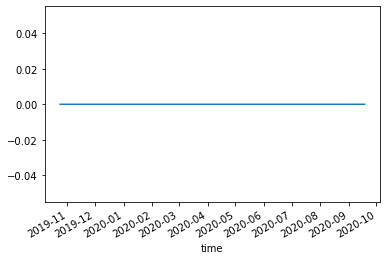

In [13]:
df_tower_withUC_cleaned.down_long_hemisp_qc.plot()

In [26]:
df_tower_withUC_cleaned.reset_index().to_csv('../data/tables/surface_obs_MOSAiC.csv')

-> Apparently, all data where the quality flags were not ok was set to NaN (see also global DS documentation on uncertainties). No need to remove data.

# Match timestamps of the different measurements 

A “nearest” search selects the row in the right DataFrame whose ‘on’ key is closest in absolute distance to the left’s key.

asof documentation:

by column name or list of column names

    Match on these columns before performing merge operation.


Use Pandas asof to only keep values from both dataframes where the times match by a tolerance timedelta. left_index/right_index=True makes the matching on the index column.

In [35]:
### test sensitivity to time tolerance
tolerances = ["1min", "2min", "3min", "5min", "10min", "30min", "1h", "2h", "6h", "100h"]

for tolerance in tolerances:
    DF = pd.merge_asof(df_sondes_sorted, df_tower_cleaned, left_index=True, right_index=True, 
                        tolerance=pd.Timedelta(tolerance),
                      allow_exact_matches=True, direction='nearest').dropna()
    print("tolerance: ",tolerance)
    print("number of data points :", len(DF))
    print("")

tolerance:  1min
number of data points : 112

tolerance:  2min
number of data points : 217

tolerance:  3min
number of data points : 323

tolerance:  5min
number of data points : 521

tolerance:  10min
number of data points : 521

tolerance:  30min
number of data points : 522

tolerance:  1h
number of data points : 526

tolerance:  2h
number of data points : 531

tolerance:  6h
number of data points : 540

tolerance:  100h
number of data points : 588



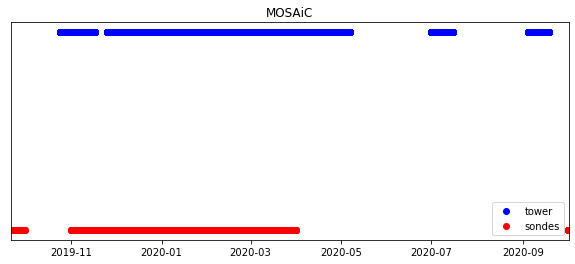

In [36]:
#create a vector of 10 min time steps with no gaps 
times = pd.date_range(start=min(df_tower_cleaned.index[0],df_sondes_sorted.index[0]),
                      end=max(df_tower_cleaned.index[-1],df_sondes_sorted.index[-1]),
                      freq='1min')

#this line creates a new df, with nan values for each missing time step 
df_tower_cleaned_interped = df_tower_cleaned.reindex(times, method='nearest', tolerance=pd.Timedelta('1min'))
df_sondes_interped = df_sondes_sorted.reindex(times, method='nearest', tolerance=pd.Timedelta('1min'))

fig = plt.subplots(figsize=(10, 4))
plt.scatter(times, df_tower_cleaned_interped['down_long_hemisp']*0+2, c='blue', label='tower')
plt.scatter(times, df_sondes_interped['T850']*0+1, c='red', label='sondes')
plt.xlim(df_sondes_sorted.index[0], df_sondes_sorted.index[-1])
plt.yticks([])
plt.legend()
plt.title('MOSAiC')
plt.show()


time to 95% autocorrelation (mins):  19.4


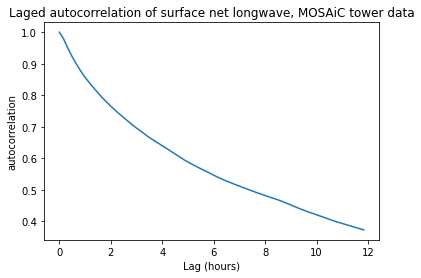

In [37]:
### test autocorrelation timescale of MOSAiC surface obs

# the tower data has a few gaps in it, we need to replace those gaps with nan rows to calculate acf

#create a vector of 10 min time steps with no gaps 
times = pd.date_range(start=df_tower_cleaned.index[0], end=df_tower_cleaned.index[-1], freq='10min')

#this line creates a new df, with nan values for each missing time step 
df_tower_cleaned_interped = df_tower_cleaned.reindex(times)

data = df_tower_cleaned_interped['down_long_hemisp'] - df_tower_cleaned_interped['up_long_hemisp']
lags = np.arange(0, 12*6, 1)
acorr = sm.tsa.acf(data, nlags = len(lags)-1, missing='conservative')
ts = np.interp(0.95, fp=np.flip(lags), xp=np.flip(acorr))
print('time to 95% autocorrelation (mins): ', np.round(ts*10,2))
plt.plot(lags/6, acorr)
plt.title('Lagged autocorrelation of surface net longwave, MOSAiC tower data')
plt.xlabel('Lag (hours)')
plt.ylabel('autocorrelation')
plt.show()

In [45]:
tolerance = "5min"
DF = pd.merge_asof(df_sondes_sorted, df_tower_cleaned, left_index=True, right_index=True, 
                        tolerance=pd.Timedelta(tolerance),
                      allow_exact_matches=True, direction='nearest').dropna()
DF 


,T850,T850_uc,temp_2m,down_long_hemisp,up_long_hemisp
time,,,,,
2019-10-31 22:59:44.757,-21.489691,0.219135,-24.069671,188.619032,216.363115
2019-11-01 05:01:15.315,-23.888647,0.233635,-18.980707,229.998433,238.340023
2019-11-01 11:00:33.717,-24.024573,0.225512,-18.393482,231.076271,240.346188
2019-11-01 16:55:55.040,-24.602744,0.216467,-18.793468,228.180734,239.207010
2019-11-01 22:59:01.759,-25.219656,0.139481,-18.792973,226.193421,239.193786
...,...,...,...,...,...
2020-03-30 10:55:36.405,-21.067786,0.243879,-28.593805,152.498662,198.459762
2020-03-30 16:59:06.827,-22.123877,0.241679,-28.695493,151.457912,196.614536
2020-03-30 22:49:48.310,-21.316428,0.242134,-29.904998,153.362517,194.775275


In [46]:
DF['month'] = DF.index.month
DF['rlns'] = DF['down_long_hemisp'] - DF['up_long_hemisp']
DF['low_level_stability'] = DF['T850']-DF['temp_2m']

DF.to_csv('../data/tables/MOSAiC_merged.csv')

### end

In [ ]:
timedelta = "10min"
df_allvars = pd.merge_asof(df_tower_cleaned, df_sondes_sorted, left_index=True, right_index=True, 
                           tolerance=pd.Timedelta(timedelta),
                           allow_exact_matches=True, direction='nearest') 

df_allvars = df_allvars.dropna(axis=0, how='any')    # only keep rows where we have all data
df_allvars

In [ ]:
df_allvars.plot(ls='',marker='.',ms=2)

# Resample to 6-hourly resolution
to have a fair comparison to the 6-hourly model data

In [ ]:
df_resampled = df_allvars.resample('6h',origin='start').mean()
df_resampled

In [ ]:
df_resampled.plot(ls='',marker='.',ms=2)

# Sort and make nice

In [ ]:
#list(df_resampled.keys())
df_resampled = df_resampled.rename(columns={"temp_2m": "T2m", "down_long_hemisp": "LWdown", "up_long_hemisp": "LWup"})
df_final = df_resampled[['T2m', 'T850', 'LWdown', 'LWup', 'T850_uc']]
df_final

# Export CSV

In [ ]:
df_final.to_csv(f'mosaic_obs_T850_rad_timedelta{timedelta}.csv')

# Investigate low-level stability

In [ ]:
stab = df_final.T850 - df_final.T2m

In [ ]:
plt.figure()
sns.kdeplot(data=stab,c='blue',label='resampled to 6hr')
sns.kdeplot(data=(df_allvars.T850 - df_allvars.temp_2m),c='red',label='not resampled')
plt.xlabel('Low-level stability [degree C]')
plt.title('Mosaic obs')
plt.xlim(-30,30)
plt.ylim(None,0.18)
plt.legend()
plt.show()

# Bivariate histograms of surface downward long-wave radiation against low level stability

In [ ]:
LWnet = df_final.LWdown - df_final.LWup

**Plot with resampled data**

In [ ]:
sns.histplot(x=stab, y=LWnet,cmap='turbo',bins=20)

**Plot with non-resampled data**

In [ ]:
sns.histplot(x=(df_allvars.T850-df_allvars.temp_2m), y=(df_allvars.down_long_hemisp - df_allvars.up_long_hemisp),cmap='turbo',bins=20)